In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Imports 

In [48]:
import warnings
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


<IPython.core.display.Javascript object>

## Functions (thanks Adam!)

In [3]:
def top_corrs(df, column, n=10):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(10)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()


def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

query = """
SELECT *
FROM houseprices
"""

df = pd.read_sql_query("SELECT * FROM houseprices", con=engine)

engine.dispose()

<IPython.core.display.Javascript object>

In [5]:
df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

## Data Inspection and Cleaning 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

<IPython.core.display.Javascript object>

In [7]:
# Since saleprice is Target, drop any rows missing this value
df = df.dropna(subset=["saleprice"])

<IPython.core.display.Javascript object>

In [8]:
df.isna().mean().sort_values(ascending=False).head(10)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagecond      0.055479
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
dtype: float64

<IPython.core.display.Javascript object>

## Inspect Target Variable - saleprice

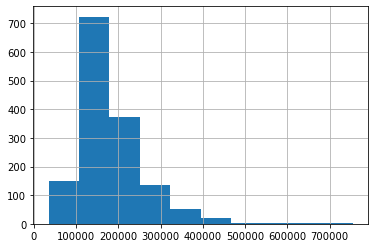

<IPython.core.display.Javascript object>

In [9]:
df["saleprice"].hist()
plt.show()

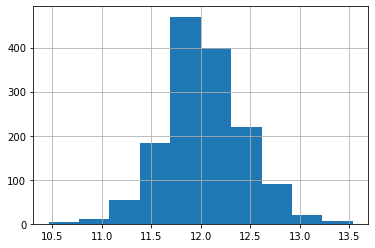

<IPython.core.display.Javascript object>

In [10]:
# saleprice has postiive skew, log seems to fix
np.log(df["saleprice"]).hist()
plt.show()

In [11]:
# make a DataFrame with the log of saleprice replacing saleprice
df_sp_log = df.copy()
df_sp_log["log_saleprice"] = np.log(df["saleprice"])
df_sp_log = df_sp_log.drop(columns=["saleprice"])

<IPython.core.display.Javascript object>

In [12]:
top_cols = top_corrs(df_sp_log, "log_saleprice")
top_cols

,corr,abs_corr
log_saleprice,1.000000,1.000000
overallqual,0.817184,0.817184
grlivarea,0.700927,0.700927
garagecars,0.680625,0.680625
garagearea,0.650888,0.650888
totalbsmtsf,0.612134,0.612134
firstflrsf,0.596981,0.596981
fullbath,0.594771,0.594771
yearbuilt,0.586570,0.586570
yearremodadd,0.565608,0.565608


<IPython.core.display.Javascript object>

In [13]:
df_sp_log

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,log_saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,12.072541
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,2,2010,WD,Normal,12.254863
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,12.493130
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2010,WD,Normal,11.864462


<IPython.core.display.Javascript object>

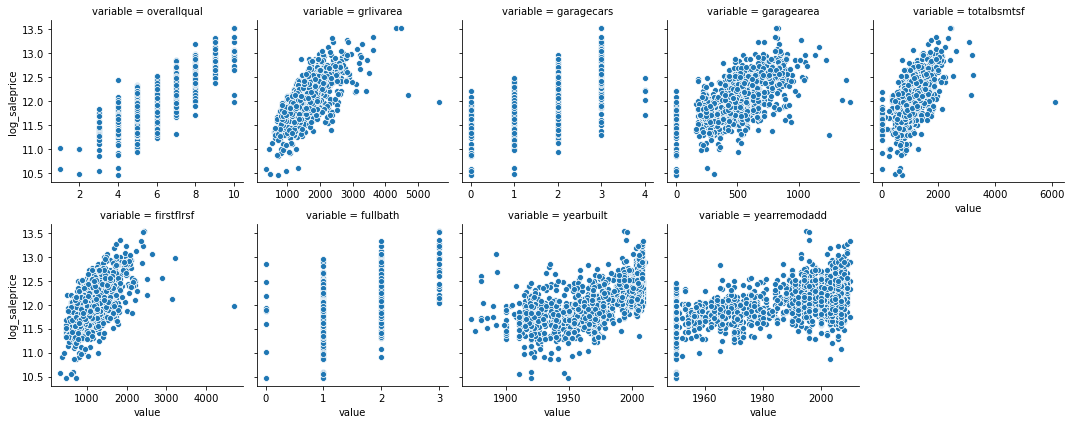

<IPython.core.display.Javascript object>

In [14]:
plot_top_corrs(df_sp_log, "log_saleprice")

In [15]:
# dropping 4 largest houses, as they appear to be creating high leverage outliers.
drop_big_houses = df_sp_log.sort_values("firstflrsf", ascending=False).iloc[:4].index

<IPython.core.display.Javascript object>

In [16]:
df_sp_log = df_sp_log.drop(index=drop_big_houses)

<IPython.core.display.Javascript object>

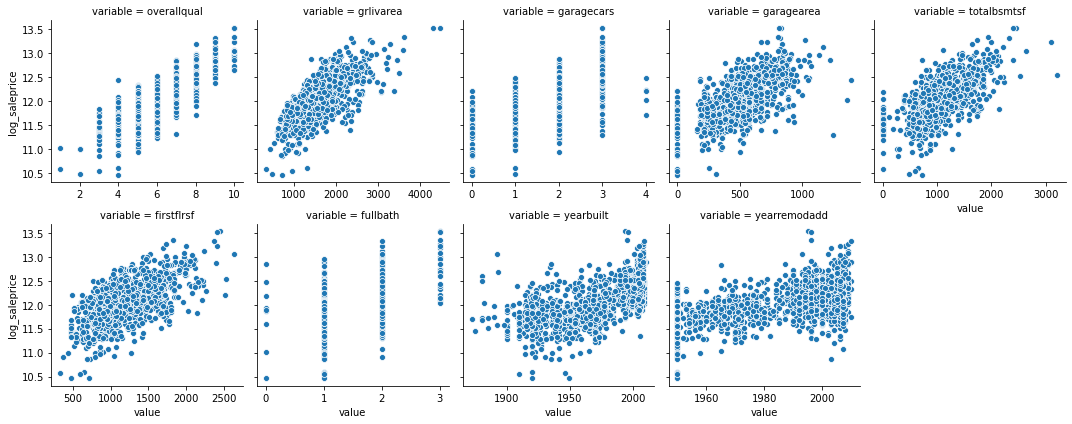

<IPython.core.display.Javascript object>

In [17]:
# removed almost all of the outliers,
plot_top_corrs(df_sp_log, "log_saleprice")

In [18]:
na_cols = df_sp_log.isna().mean().sort_values(ascending=False).head(19).index

<IPython.core.display.Javascript object>

In [19]:
# after inspecting columns with na's, none are important, so dropping
df_clean = df_sp_log.drop(columns=na_cols)

<IPython.core.display.Javascript object>

In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 62 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1456 non-null   int64  
 1   mssubclass     1456 non-null   int64  
 2   mszoning       1456 non-null   object 
 3   lotarea        1456 non-null   int64  
 4   street         1456 non-null   object 
 5   lotshape       1456 non-null   object 
 6   landcontour    1456 non-null   object 
 7   utilities      1456 non-null   object 
 8   lotconfig      1456 non-null   object 
 9   landslope      1456 non-null   object 
 10  neighborhood   1456 non-null   object 
 11  condition1     1456 non-null   object 
 12  condition2     1456 non-null   object 
 13  bldgtype       1456 non-null   object 
 14  housestyle     1456 non-null   object 
 15  overallqual    1456 non-null   int64  
 16  overallcond    1456 non-null   int64  
 17  yearbuilt      1456 non-null   int64  
 18  yearremo

<IPython.core.display.Javascript object>

In [21]:
# interested in whether a house has a pool or not, but not size
if [df_clean["poolarea"] > 0] == True:
    df_clean["haspool"] = 1
else:
    df_clean["haspool"] = 0

df_clean = df_clean.drop(columns="poolarea")

<IPython.core.display.Javascript object>

In [22]:
# Basement full bath + abv ground full bath = total full bath
df_clean['fullbath'] = df_clean['fullbath'] +df_clean['bsmtfullbath']
df_clean = df_clean.drop(columns='bsmtfullbath')


<IPython.core.display.Javascript object>

In [23]:
# dropping 4 largest lot areas, as they appear to be creating high leverage outliers.
drop_big_lots = df_clean.sort_values("lotarea", ascending=False).iloc[:4].index
df_clean = df_clean.drop(index=drop_big_lots)

<IPython.core.display.Javascript object>

In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1459
Data columns (total 61 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1452 non-null   int64  
 1   mssubclass     1452 non-null   int64  
 2   mszoning       1452 non-null   object 
 3   lotarea        1452 non-null   int64  
 4   street         1452 non-null   object 
 5   lotshape       1452 non-null   object 
 6   landcontour    1452 non-null   object 
 7   utilities      1452 non-null   object 
 8   lotconfig      1452 non-null   object 
 9   landslope      1452 non-null   object 
 10  neighborhood   1452 non-null   object 
 11  condition1     1452 non-null   object 
 12  condition2     1452 non-null   object 
 13  bldgtype       1452 non-null   object 
 14  housestyle     1452 non-null   object 
 15  overallqual    1452 non-null   int64  
 16  overallcond    1452 non-null   int64  
 17  yearbuilt      1452 non-null   int64  
 18  yearremo

<IPython.core.display.Javascript object>

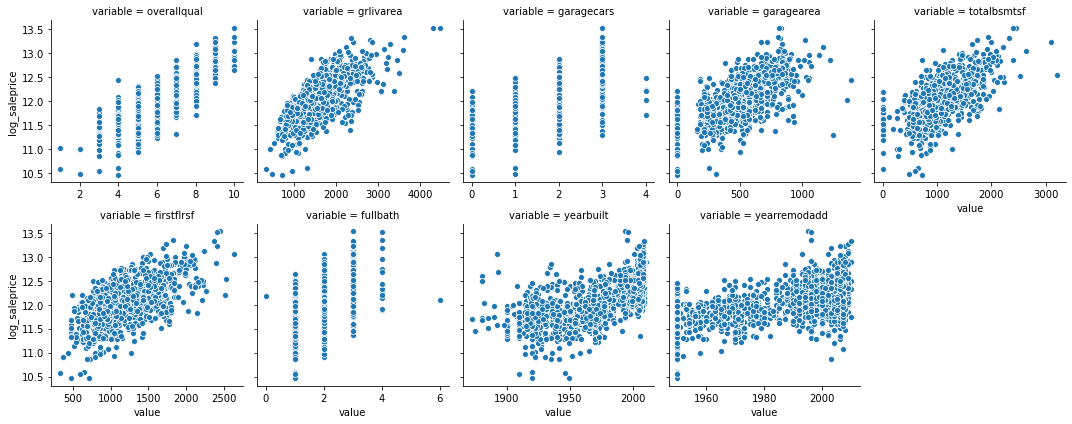

<IPython.core.display.Javascript object>

In [25]:
plot_top_corrs(df_clean, "log_saleprice")

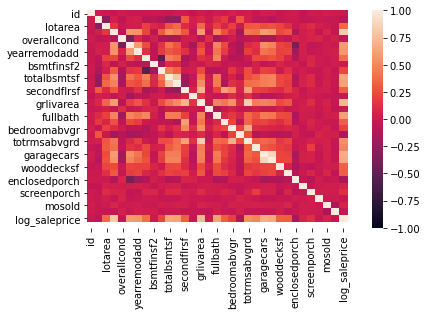

<IPython.core.display.Javascript object>

In [26]:
sns.heatmap(df_clean.corr(), vmin=-1)
plt.show()

In [27]:
# Choosing features for model

feature_cols = [
    "lotarea",
    "overallqual",
    "grlivarea",
    "fullbath",
    "fireplaces",
    "garagecars",
    "log_saleprice",
]

<IPython.core.display.Javascript object>

In [28]:
feature_df = df_clean[feature_cols]

<IPython.core.display.Javascript object>

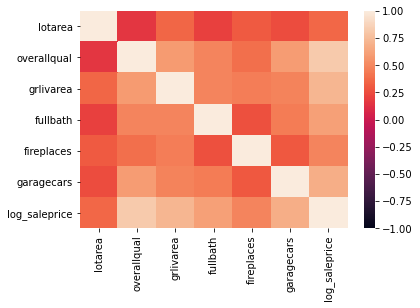

<IPython.core.display.Javascript object>

In [29]:
sns.heatmap(feature_df.corr(), vmin=-1)
plt.show()

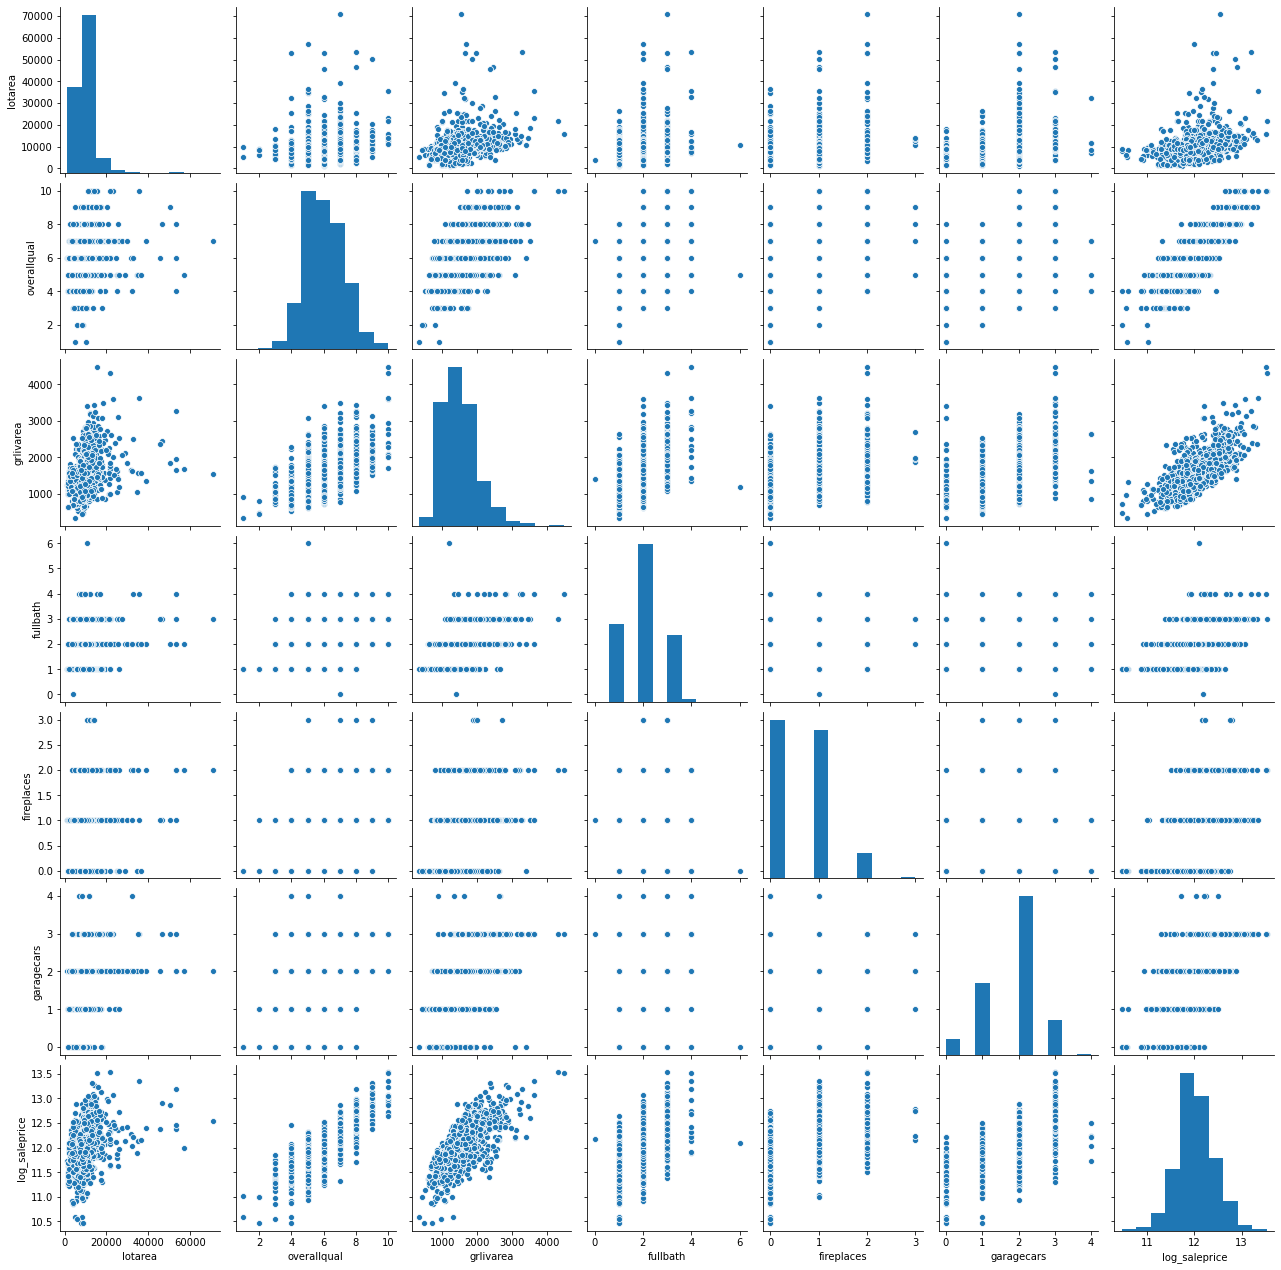

<IPython.core.display.Javascript object>

In [31]:
sns.pairplot(feature_df)
plt.show()

## Build Model

In [41]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lotarea        1452 non-null   int64  
 1   overallqual    1452 non-null   int64  
 2   grlivarea      1452 non-null   int64  
 3   fullbath       1452 non-null   int64  
 4   fireplaces     1452 non-null   int64  
 5   garagecars     1452 non-null   int64  
 6   log_saleprice  1452 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 130.8 KB


<IPython.core.display.Javascript object>

In [40]:
print_vif(feature_df.drop(columns=["log_saleprice"]))

VIF results
-------------------------------
const          24.390788
lotarea         1.222572
overallqual     2.085096
grlivarea       1.943976
fullbath        1.477561
fireplaces      1.352149
garagecars      1.711802
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [32]:
X = feature_df.drop(columns="log_saleprice")
y = feature_df["log_saleprice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [33]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

<IPython.core.display.Javascript object>

In [34]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_train, y_train)

<IPython.core.display.Javascript object>

In [35]:
train_score

0.8430845469213601

<IPython.core.display.Javascript object>

In [36]:
test_score

0.8430845469213601

<IPython.core.display.Javascript object>

In [37]:
print(model.intercept_)
print(model.coef_)

10.499337999638401
[8.00088233e-06 1.34316111e-01 1.77863733e-04 8.56334127e-02
 4.73486840e-02 9.16568321e-02]


<IPython.core.display.Javascript object>

In [38]:
y_pred = model.predict(X_test)

<IPython.core.display.Javascript object>

In [39]:
import statsmodels.api as sm

X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1211.
Date:                Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:02:55   Log-Likelihood:                 581.12
No. Observations:                1452   AIC:                            -1148.
Df Residuals:                    1445   BIC:                            -1111.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.4969      0.021    498.232      0.000      10.456      10.538
lotarea      8.273e-06   8.71e-07      9.500      0.000    6.56e-06    9.98e-06
overallqual     0.1344      0.004     30.020      0.000       0.126       0.143
grlivarea       0.0002   1.18e-05     14.122      0.000       0.000       0.000
fullbath        0.0879      0.007     12.265      0.000       0.074       0.102
fireplaces      0.0482      0.008      6.201      0.000       0.033       0.063
garagecars      0.0957      0.007     12.824      0.000       0.081       0.110
==============================================================================
Omnibus:                      251.563   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              689.789
Skew:                          -0.904   Prob(JB):                    1.64e-150
Kurtosis:                       5.851   Cond. No.                     5.78e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

My models goodness of fits topped out with a R-squared of about 84%. All coefficients P-values are 0, meaning they are all statistically significant. 

Interpretation: 

log(saleprice) = 10.49 + (.000008273 * lotarea) + (.1344 * overallqual) + (.0002 * grlivarea) + (0.0879 * fullbath) + (0.0482 * fireplaces) + (0.0957 * garagecars)
    
    

## Predictions 

In [42]:
pred_df = X_test.copy()

<IPython.core.display.Javascript object>

In [44]:
pred_df["actual"] = np.exp(y_test)
pred_df = pred_df.reset_index()

<IPython.core.display.Javascript object>

In [46]:
pred_df["predicted"] = np.exp(model.predict(X_test))

<IPython.core.display.Javascript object>

In [50]:
pred_df["residual"] = pred_df["predicted"] - pred_df["actual"]
pred_df["abs_residuals"] = pred_df["residual"].abs()
pred_df["perc_residuals"] = pred_df["abs_residuals"] / pred_df["actual"]

<IPython.core.display.Javascript object>

In [52]:
print(f'Mean Absolute Error: ${pred_df["abs_residuals"].mean():.2f}')
print(f'Mean Absolute Percent Error: {pred_df["perc_residuals"].mean() * 100:.2f}%')

Mean Absolute Error: $20199.56
Mean Absolute Percent Error: 14.18%


<IPython.core.display.Javascript object>

The best that I could get the model was a MAE of $20,199.56, which is a MAPE of 14.18%. At this point I am happy with this result, but I will continue to tweak my model in hopes of getting lower numbers than that. 